dataset link : https://www.kaggle.com/datasets/subhaditya/fer2013plus

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torchvision import transforms, models
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchvision.models import EfficientNet_V2_S_Weights
from torchvision.models import resnet18


In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import os

class FERPlusImageFolderDataModule:
    def __init__(self, root_dir, batch_size=64):
        self.train_dir = os.path.join(root_dir, "train")
        self.test_dir = os.path.join(root_dir, "test")
        self.batch_size = batch_size
        

        
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        
        self.eval_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),  # Ensure grayscale
            transforms.Resize((224, 224)),                  # Standard FER size
            transforms.ToTensor(),                        # Convert to [0,1] tensor
            transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize grayscale
        ])

    def setup(self):
        self.train_dataset = ImageFolder(self.train_dir, transform=self.train_transform)
        self.test_dataset = ImageFolder(self.test_dir, transform=self.eval_transform)


        print("Train class distribution:")
        for cls in self.train_dataset.classes:
            count = len([x for x in self.train_dataset.samples if x[1] == self.train_dataset.class_to_idx[cls]])
        print(f"{cls}: {count}")

        
        # Split test into val + test manually (optional)
        val_size = int(0.5 * len(self.test_dataset))
        test_size = len(self.test_dataset) - val_size
        self.val_dataset, self.test_dataset = torch.utils.data.random_split(
            self.test_dataset, [val_size, test_size], generator=torch.Generator().manual_seed(42)
        )
    def train_dataloader(self):
        return DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=4)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2)


In [3]:
class EmotionDetectorResNet18(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectorResNet18, self).__init__()
        self.model = resnet18(weights='IMAGENET1K_V1')  # Pretrained weights

        # Modify for grayscale input
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace final classifier
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [4]:
class EmotionDetectorMobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectorMobileNetV2, self).__init__()
        self.model = models.mobilenet_v2(pretrained=True)  # Using MobileNetV2 as base model

        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        # Modify the classifier to match our problem
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=0.7),  # Increased dropout to 50%
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

class EmotionDetectorEffNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionDetectorEffNet, self).__init__()

        # Load EfficientNetV2-S with pretrained weights
        self.model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)

        # Modify the first conv layer to accept grayscale (1-channel)
        # Original: Conv2d(3, 24, ...)
        old_conv = self.model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=False
        )

        # Convert pretrained RGB weights to grayscale by summing over the input channels
        with torch.no_grad():
            new_conv.weight.copy_(old_conv.weight.sum(dim=1, keepdim=True))

        self.model.features[0][0] = new_conv  # Replace first conv with grayscale conv

        # Replace the classifier head
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(self.model.classifier[1].in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import *
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm


def train_model(model, train_loader, val_loader, num_epochs, device, save_path="best_model.pth", lr=0.01, use_tqdm=True, train_dataset=None, early_stop_patience=10):
    model = model.to(device)
    labels = torch.tensor([s[1] for s in train_dataset.samples], dtype=torch.long)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    warmup_epochs = 5  # You can adjust this
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }

    best_val_acc = 0.0
    best_val_loss = float('inf')  # Initialize best_val_loss with infinity
    best_model_path = save_path
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]") if use_tqdm else train_loader
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_bar.set_postfix(loss=running_loss / total, acc=100. * correct / total)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []

        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]") if use_tqdm else val_loader
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                val_bar.set_postfix(loss=val_loss / val_total, acc=100. * val_correct / val_total)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100. * val_correct / val_total

        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average='weighted', zero_division=0
        )

        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)
        history['val_f1'].append(f1)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print(f"Val Precision: {precision:.4f}, Val Recall: {recall:.4f}, Val F1: {f1:.4f}")

        # Save best model based on both accuracy and loss
        if epoch_val_acc > best_val_acc and epoch_val_loss < best_val_loss:
            best_val_acc = epoch_val_acc
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with Val Acc: {best_val_acc:.2f}% and Val Loss: {best_val_loss:.4f} at {best_model_path}")
            no_improve_epochs = 0  # reset early stopping counter
        # else:
        #     no_improve_epochs += 1
        #     if no_improve_epochs >= early_stop_patience:
        #         print(f"Early stopping triggered after {early_stop_patience} epochs without improvement.")
        #         break

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scheduler.step(epoch_val_loss)

    final_model_path = save_path.replace(".pth", "_final.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

    return history



def test_model(model, test_loader, device, test_dataset=None):
    """
    Test function to evaluate the model on a test dataset.

    Args:
        model: Trained CNN model
        test_loader: DataLoader for test data
        device: Device to test on ('cuda' or 'cpu')
        test_dataset: Optional: dataset for calculating class weights (if needed)

    Returns:
        test_loss: Average test loss
        test_acc: Test accuracy
        precision: Weighted precision
        recall: Weighted recall
        f1: Weighted F1-score
    """
    print("Testing")
    model.load_state_dict(torch.load("best_emotion_model.pth"))
    model = model.to(device)
    model.eval()

    labels = torch.tensor([s[1] for s in test_dataset.dataset.samples], dtype=torch.long)
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    test_bar = tqdm(test_loader, desc="Testing")  # Add a progress bar for testing
    with torch.no_grad():
        for inputs, labels in test_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_bar.set_postfix(loss=test_loss / total, acc=100. * correct / total)

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = 100. * correct / total

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )

    print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1: {f1:.4f}")

    return test_loss, test_acc, precision, recall, f1, all_preds, all_labels


In [7]:
# class WeightedCrossEntropyLoss(nn.Module):
#     def __init__(self, labels, device, num_classes=8):
#         super().__init__()
#         self.device = device
#         self.num_classes = num_classes
#         self.weights = self.__compute_weights(labels).to(device)
#         self.loss = nn.CrossEntropyLoss(weight=self.weights)

#     def __compute_weights(self, labels):
#         class_counts = torch.bincount(labels, minlength=self.num_classes)
#         total_samples = len(labels)
#         weights = total_samples / (self.num_classes * class_counts.float())
#         return weights

#     def forward(self, outputs, targets):
#         return self.loss(outputs, targets)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_loss_curve(train_loss, val_loss):
    """    
    Plots the training and validation loss curves.
    
    Parameters:       
    - train_loss: List of training loss values per epoch
    - val_loss: List of validation loss values per epoch
    """
    #Loss curve , still don't know list names 
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy_curve(train_acc, val_acc):
    """
    Plots training and validation accuracy per epoch.
    
    Args:
        train_acc (list): Training accuracy values
        val_acc (list): Validation accuracy values
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))



Train class distribution:
6: 6187


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 186MB/s]
Epoch 1/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.39it/s, acc=53.6, loss=1.3] 



Epoch 1/30
Train Loss: 1.7238, Train Acc: 33.32%
Val Loss: 1.2955, Val Acc: 53.58%
Val Precision: 0.4955, Val Recall: 0.5358, Val F1: 0.4774
Best model saved with Val Acc: 53.58% and Val Loss: 1.2955 at best_emotion_model.pth


Epoch 2/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.52it/s, acc=68.9, loss=0.872]



Epoch 2/30
Train Loss: 1.1345, Train Acc: 59.34%
Val Loss: 0.8720, Val Acc: 68.85%
Val Precision: 0.6760, Val Recall: 0.6885, Val F1: 0.6555
Best model saved with Val Acc: 68.85% and Val Loss: 0.8720 at best_emotion_model.pth


Epoch 3/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.57it/s, acc=74.4, loss=0.714]



Epoch 3/30
Train Loss: 0.8772, Train Acc: 68.61%
Val Loss: 0.7139, Val Acc: 74.42%
Val Precision: 0.7363, Val Recall: 0.7442, Val F1: 0.7309
Best model saved with Val Acc: 74.42% and Val Loss: 0.7139 at best_emotion_model.pth


Epoch 4/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.56it/s, acc=77, loss=0.629]  



Epoch 4/30
Train Loss: 0.7416, Train Acc: 73.03%
Val Loss: 0.6287, Val Acc: 76.96%
Val Precision: 0.7719, Val Recall: 0.7696, Val F1: 0.7629
Best model saved with Val Acc: 76.96% and Val Loss: 0.6287 at best_emotion_model.pth


Epoch 5/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.54it/s, acc=79.2, loss=0.573]



Epoch 5/30
Train Loss: 0.6480, Train Acc: 76.65%
Val Loss: 0.5729, Val Acc: 79.24%
Val Precision: 0.7931, Val Recall: 0.7924, Val F1: 0.7866
Best model saved with Val Acc: 79.24% and Val Loss: 0.5729 at best_emotion_model.pth


Epoch 6/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.50it/s, acc=80.8, loss=0.53] 



Epoch 6/30
Train Loss: 0.5833, Train Acc: 78.87%
Val Loss: 0.5300, Val Acc: 80.76%
Val Precision: 0.8081, Val Recall: 0.8076, Val F1: 0.8049
Best model saved with Val Acc: 80.76% and Val Loss: 0.5300 at best_emotion_model.pth


Epoch 7/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.56it/s, acc=81, loss=0.51]   



Epoch 7/30
Train Loss: 0.5357, Train Acc: 80.28%
Val Loss: 0.5101, Val Acc: 80.95%
Val Precision: 0.8089, Val Recall: 0.8095, Val F1: 0.8055
Best model saved with Val Acc: 80.95% and Val Loss: 0.5101 at best_emotion_model.pth


Epoch 8/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.46it/s, acc=81.2, loss=0.504]



Epoch 8/30
Train Loss: 0.4874, Train Acc: 82.25%
Val Loss: 0.5044, Val Acc: 81.23%
Val Precision: 0.8129, Val Recall: 0.8123, Val F1: 0.8091
Best model saved with Val Acc: 81.23% and Val Loss: 0.5044 at best_emotion_model.pth


Epoch 9/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.54it/s, acc=82.3, loss=0.488]



Epoch 9/30
Train Loss: 0.4513, Train Acc: 83.51%
Val Loss: 0.4878, Val Acc: 82.33%
Val Precision: 0.8249, Val Recall: 0.8233, Val F1: 0.8222
Best model saved with Val Acc: 82.33% and Val Loss: 0.4878 at best_emotion_model.pth


Epoch 10/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.49it/s, acc=82.2, loss=0.482]



Epoch 10/30
Train Loss: 0.4171, Train Acc: 84.75%
Val Loss: 0.4823, Val Acc: 82.19%
Val Precision: 0.8231, Val Recall: 0.8219, Val F1: 0.8196


Epoch 11/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.49it/s, acc=82.9, loss=0.477]



Epoch 11/30
Train Loss: 0.3830, Train Acc: 85.99%
Val Loss: 0.4773, Val Acc: 82.91%
Val Precision: 0.8295, Val Recall: 0.8291, Val F1: 0.8278
Best model saved with Val Acc: 82.91% and Val Loss: 0.4773 at best_emotion_model.pth


Epoch 12/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.48it/s, acc=82.9, loss=0.484]



Epoch 12/30
Train Loss: 0.3601, Train Acc: 87.09%
Val Loss: 0.4839, Val Acc: 82.86%
Val Precision: 0.8315, Val Recall: 0.8286, Val F1: 0.8257


Epoch 13/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.48it/s, acc=83.2, loss=0.49] 



Epoch 13/30
Train Loss: 0.3305, Train Acc: 88.21%
Val Loss: 0.4896, Val Acc: 83.16%
Val Precision: 0.8323, Val Recall: 0.8316, Val F1: 0.8281


Epoch 14/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.53it/s, acc=83.8, loss=0.474]



Epoch 14/30
Train Loss: 0.3003, Train Acc: 89.39%
Val Loss: 0.4744, Val Acc: 83.79%
Val Precision: 0.8376, Val Recall: 0.8379, Val F1: 0.8367
Best model saved with Val Acc: 83.79% and Val Loss: 0.4744 at best_emotion_model.pth


Epoch 15/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.51it/s, acc=83.4, loss=0.494]



Epoch 15/30
Train Loss: 0.2745, Train Acc: 90.14%
Val Loss: 0.4944, Val Acc: 83.38%
Val Precision: 0.8342, Val Recall: 0.8338, Val F1: 0.8321


Epoch 16/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.53it/s, acc=84.2, loss=0.494]



Epoch 16/30
Train Loss: 0.2496, Train Acc: 91.37%
Val Loss: 0.4936, Val Acc: 84.23%
Val Precision: 0.8433, Val Recall: 0.8423, Val F1: 0.8415


Epoch 17/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.54it/s, acc=83.6, loss=0.517]



Epoch 17/30
Train Loss: 0.2230, Train Acc: 92.13%
Val Loss: 0.5173, Val Acc: 83.57%
Val Precision: 0.8353, Val Recall: 0.8357, Val F1: 0.8343


Epoch 18/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.56it/s, acc=84.1, loss=0.511]



Epoch 18/30
Train Loss: 0.2079, Train Acc: 92.76%
Val Loss: 0.5109, Val Acc: 84.10%
Val Precision: 0.8402, Val Recall: 0.8410, Val F1: 0.8401


Epoch 19/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.55it/s, acc=83.7, loss=0.543]



Epoch 19/30
Train Loss: 0.1919, Train Acc: 93.16%
Val Loss: 0.5432, Val Acc: 83.71%
Val Precision: 0.8378, Val Recall: 0.8371, Val F1: 0.8351


Epoch 20/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.49it/s, acc=84.1, loss=0.54] 



Epoch 20/30
Train Loss: 0.1741, Train Acc: 93.89%
Val Loss: 0.5400, Val Acc: 84.12%
Val Precision: 0.8401, Val Recall: 0.8412, Val F1: 0.8398


Epoch 21/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.53it/s, acc=83.4, loss=0.556]



Epoch 21/30
Train Loss: 0.1594, Train Acc: 94.47%
Val Loss: 0.5559, Val Acc: 83.43%
Val Precision: 0.8334, Val Recall: 0.8343, Val F1: 0.8328


Epoch 22/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.53it/s, acc=83.7, loss=0.588]



Epoch 22/30
Train Loss: 0.1428, Train Acc: 95.01%
Val Loss: 0.5880, Val Acc: 83.71%
Val Precision: 0.8377, Val Recall: 0.8371, Val F1: 0.8355


Epoch 23/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.58it/s, acc=83.9, loss=0.586]



Epoch 23/30
Train Loss: 0.1309, Train Acc: 95.56%
Val Loss: 0.5864, Val Acc: 83.90%
Val Precision: 0.8390, Val Recall: 0.8390, Val F1: 0.8375


Epoch 24/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.51it/s, acc=83.9, loss=0.593]



Epoch 24/30
Train Loss: 0.1202, Train Acc: 95.93%
Val Loss: 0.5933, Val Acc: 83.90%
Val Precision: 0.8381, Val Recall: 0.8390, Val F1: 0.8376


Epoch 25/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.44it/s, acc=83.7, loss=0.612]



Epoch 25/30
Train Loss: 0.1165, Train Acc: 96.03%
Val Loss: 0.6122, Val Acc: 83.65%
Val Precision: 0.8369, Val Recall: 0.8365, Val F1: 0.8348


Epoch 26/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.47it/s, acc=83.9, loss=0.599]



Epoch 26/30
Train Loss: 0.1091, Train Acc: 96.29%
Val Loss: 0.5988, Val Acc: 83.88%
Val Precision: 0.8378, Val Recall: 0.8388, Val F1: 0.8376


Epoch 27/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.49it/s, acc=84, loss=0.617]  



Epoch 27/30
Train Loss: 0.1016, Train Acc: 96.52%
Val Loss: 0.6165, Val Acc: 84.01%
Val Precision: 0.8397, Val Recall: 0.8401, Val F1: 0.8387


Epoch 28/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.45it/s, acc=83.8, loss=0.636]



Epoch 28/30
Train Loss: 0.0965, Train Acc: 96.63%
Val Loss: 0.6355, Val Acc: 83.77%
Val Precision: 0.8370, Val Recall: 0.8377, Val F1: 0.8356


Epoch 29/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.47it/s, acc=83.8, loss=0.63] 



Epoch 29/30
Train Loss: 0.0948, Train Acc: 96.71%
Val Loss: 0.6303, Val Acc: 83.85%
Val Precision: 0.8383, Val Recall: 0.8385, Val F1: 0.8370


Epoch 30/30 [Val]: 100%|██████████| 57/57 [00:06<00:00,  8.52it/s, acc=83.8, loss=0.645]



Epoch 30/30
Train Loss: 0.0918, Train Acc: 96.83%
Val Loss: 0.6451, Val Acc: 83.82%
Val Precision: 0.8372, Val Recall: 0.8382, Val F1: 0.8367
Final model saved at best_emotion_model_final.pth
Testing


Testing: 100%|██████████| 57/57 [00:13<00:00,  4.25it/s, acc=83.4, loss=0.492]



Test Loss: 0.4915, Test Acc: 83.38%
Test Precision: 0.8349, Test Recall: 0.8338, Test F1: 0.8333


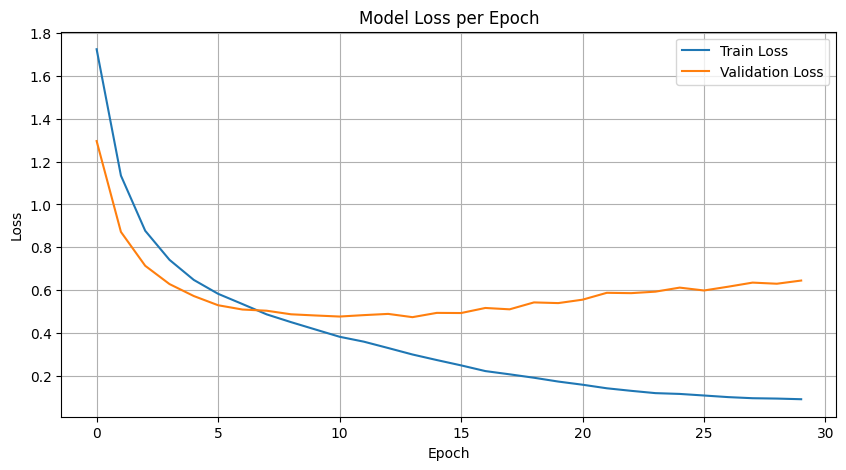

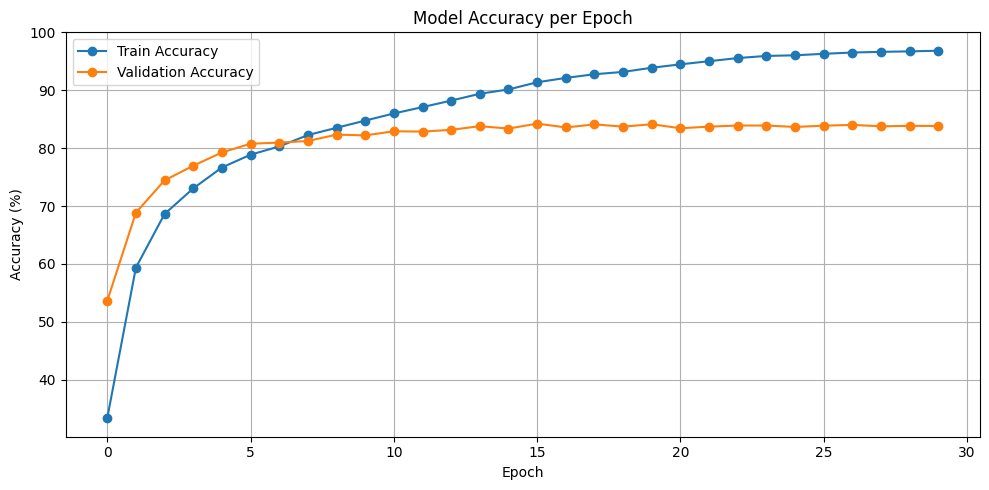

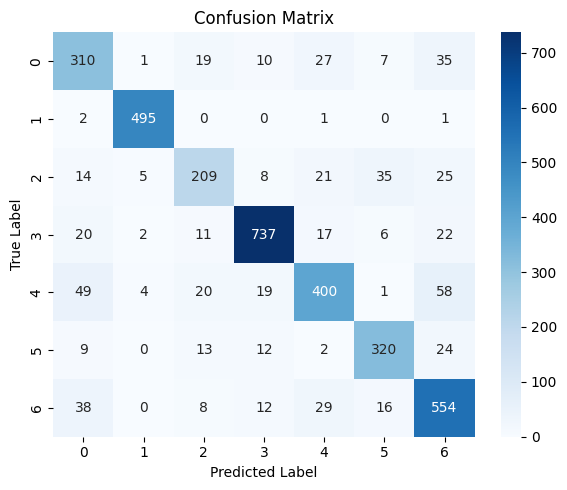


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       409
           1       0.98      0.99      0.98       499
           2       0.75      0.66      0.70       317
           3       0.92      0.90      0.91       815
           4       0.80      0.73      0.76       551
           5       0.83      0.84      0.84       380
           6       0.77      0.84      0.81       657

    accuracy                           0.83      3628
   macro avg       0.82      0.82      0.82      3628
weighted avg       0.83      0.83      0.83      3628



In [9]:
def main():
    # Config
    root_dir = "/kaggle/input/fer-dataset/FER+"
    batch_size = 64
    num_classes = 7
    num_epochs = 30
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    save_path = "best_emotion_model.pth"

    # Data setup
    data_module = FERPlusImageFolderDataModule(root_dir, batch_size)
    data_module.setup()

    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    test_loader = data_module.test_dataloader()

    model = EmotionDetectorEffNet(num_classes=num_classes)

    original_train_dataset = data_module.train_dataset
    history = train_model(model, train_loader, val_loader, num_epochs, device, save_path,
                          lr=1e-5, train_dataset=original_train_dataset)

    original_test_dataset = data_module.test_dataset
    test_loss, test_acc, precision, recall, f1, all_preds, all_labels = test_model(
        model, test_loader, device, test_dataset=original_test_dataset
    )

    
    plot_loss_curve(history['train_loss'], history['val_loss'])
    plot_accuracy_curve(history['train_acc'], history['val_acc'])
    
    class_names = data_module.train_dataset.classes
    plot_confusion_matrix(all_labels, all_preds, class_names)



if __name__ == "__main__":
    main()